In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score, recall_score, f1_score

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator, load_img
%matplotlib inline

import tensorflow as tf

Using TensorFlow backend.


In [2]:
data = pd.read_csv("./list_attr_celeba.csv")
partition = pd.read_csv("./list_eval_partition.csv")

In [3]:
IMAGEDIR='./imagenes_tp3_cv/'

## Limpieza y pre-procesado de datos:

Para poder comenzar a trabajar con los datos, es necesario eliminar todas las columnas del dataset que no vamos a utilizar. 
Nos quedaremos sólo con la columna que contiene el nombre de la imagen y nuestra variable target "Smiling" 

In [4]:
data = data.drop(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes','Bald',
                 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair','Sideburns',
                 'Blond_Hair', 'Blurry', 'Attractive', 'Brown_Hair','Bushy_Eyebrows',
                 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee','Gray_Hair',
                 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open','Mustache',
                 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin','Rosy_Cheeks',
                 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat','Wearing_Lipstick',
                 'Wearing_Necklace', 'Young','Pointy_Nose',
                 'Receding_Hairline', 'Wearing_Necktie'], axis=1)

Vamos a transformar los valores de nuestra variable target, tomando como valores '0' y '1'. Los trataremos como string, ya que para utilizar los generadores de datos de Keras es necesario que las columnas que le proveemos sean cadenas.

0 = "No sonrie" 
1= "Sonrie" 

Por otro lado, combinamos el data set con la data de "partition" a fin de tener una columna que nos indique si la imagen será utilizada en train(0), test(1) o validation(2).

In [5]:
data['Smiling'] = data['Smiling'].replace([-1], '0')
data['Smiling'] = data['Smiling'].replace([1], '1')

In [6]:
data_combinada = pd.merge(data, partition, how='inner', on = 'image_id')

In [7]:
data_combinada.head()

,image_id,Smiling,partition
0,000001.jpg,1,0
1,000002.jpg,1,0
2,000003.jpg,0,0
3,000004.jpg,0,0
4,000005.jpg,0,0


### Análisis de valores nulos

In [8]:
data_combinada.isnull().sum()

image_id     0
Smiling      0
partition    0
dtype: int64

No hay filas con valores nulos en el dataset. 

### Distribución de nuestra variable target: 

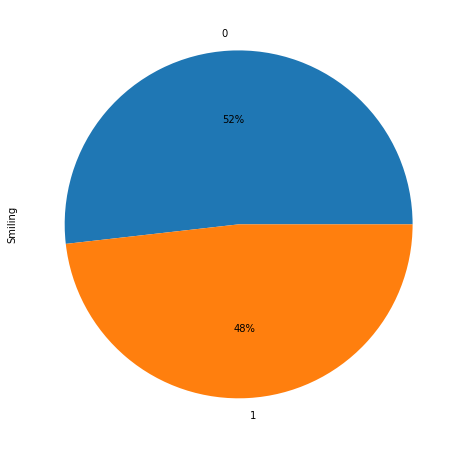

In [9]:
data_combinada.Smiling.value_counts().plot.pie(autopct='%1.0f%%', figsize=(8,8))

De acuerdo a lo observado en el gráfico que se encuentra por encima, se puede decir que nuestro dataset está balanceado, por ende podemos optar por observar el resultado de accuracy para poder determinar el rendimiento de nuestros modelos. 

### Separación de datos: Train, Test, Validation

In [10]:
data_train =data_combinada[data_combinada.partition == 0]
data_test = data_combinada[data_combinada.partition == 1]
data_validation = data_combinada[data_combinada.partition == 2]

In [11]:
#eliminanos la columna 'partition ya que no se utiliza para predecir'
data_train=data_train.drop(['partition'],axis=1)
data_test=data_test.drop(['partition'],axis=1)
data_validation=data_validation.drop(['partition'],axis=1)

In [12]:
data_train.head()

,image_id,Smiling
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [13]:
data_test.head()

,image_id,Smiling
162770,162771.jpg,1
162771,162772.jpg,1
162772,162773.jpg,0
162773,162774.jpg,1
162774,162775.jpg,0


In [14]:
data_validation.head()

,image_id,Smiling
182637,182638.jpg,1
182638,182639.jpg,0
182639,182640.jpg,1
182640,182641.jpg,1
182641,182642.jpg,1


### Cantidad de datos: Train, Test, Validation

In [15]:
data_train.shape

(162770, 2)

In [16]:
data_test.shape

(19867, 2)

In [17]:
data_validation.shape

(19962, 2)

#### Corroboramos la distribución de la variable target en data_train, data_test, data_validation

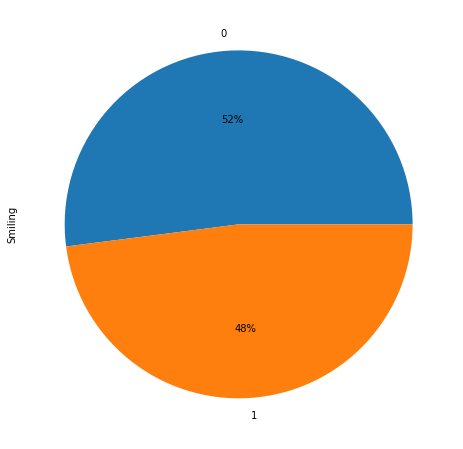

In [18]:
data_train.Smiling.value_counts().plot.pie(autopct='%1.0f%%', figsize=(8,8))

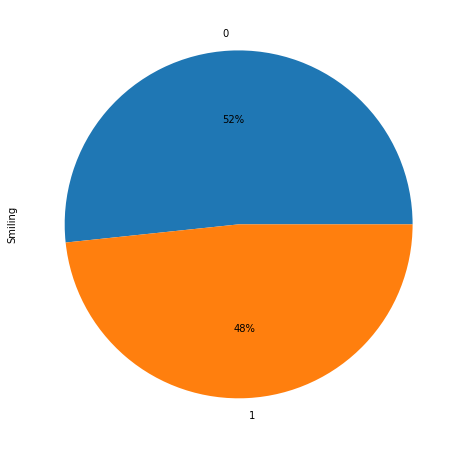

In [19]:
data_test.Smiling.value_counts().plot.pie(autopct='%1.0f%%', figsize=(8,8))

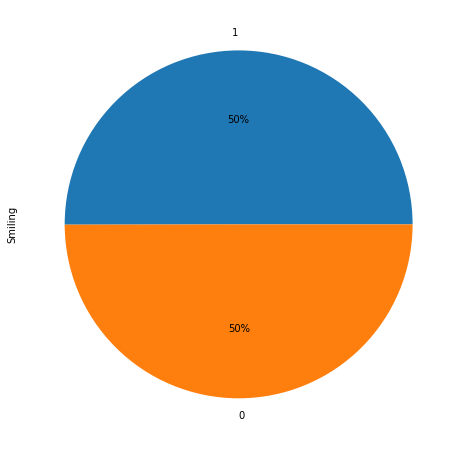

In [20]:
data_validation.Smiling.value_counts().plot.pie(autopct='%1.0f%%', figsize=(8,8))

##### Todos los dataset se encuentran balanceados. 

### Visualizamos algunos ejemplos de imágenes con los que vamos a estar trabajando

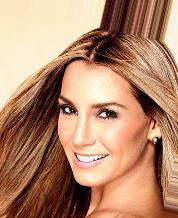

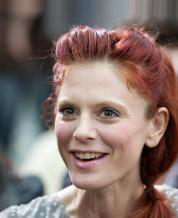

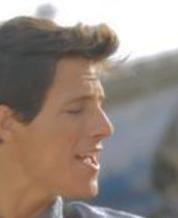

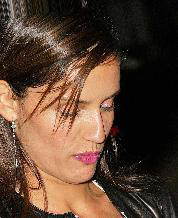

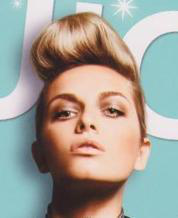

In [21]:
imagenes = os.listdir('./imagenes_tp3_cv/')

for i in range(5):
    imagen=load_img(os.path.join(IMAGEDIR,imagenes[i]))
    display(imagen)
    


A fin de hacer más ameno el trabajo y el procesamiento, transformaremos el tamaño de las imágenes a 70x70

### Praparamos los generadores

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_train,
    directory=IMAGEDIR,
    x_col='image_id',
    y_col='Smiling',
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=42,
    target_size=(70, 70)
)


test_generator=test_datagen.flow_from_dataframe(
    dataframe=data_test,
    directory=IMAGEDIR,
    x_col='image_id',
    y_col='Smiling',
    class_mode="binary",
    batch_size=32,
    shuffle=False,
    seed=42,
    target_size=(70, 70)
)


val_generator = validation_datagen.flow_from_dataframe(
    dataframe=data_validation,
    directory=IMAGEDIR,
    x_col='image_id',
    y_col='Smiling',
    class_mode="binary",
    batch_size=32,
    shuffle=False,
    seed=42,
    target_size=(70, 70)
)



Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
Found 19962 validated image filenames belonging to 2 classes.


### MLP

In [33]:
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.layers as Layers
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils import to_categorical

model_mlp_1 = Models.Sequential()

model_mlp_1.add(Layers.Flatten(input_shape=(70,70,3)))
model_mlp_1.add(Layers.Dense(510, activation="relu"))
model_mlp_2.add(Layers.Dropout(0.5))
model_mlp_1.add(Layers.Dense(310, activation="relu"))
model_mlp_2.add(Layers.Dropout(0.3))
model_mlp_1.add(Layers.Dense(210, activation="relu"))
model_mlp_2.add(Layers.Dropout(0.2))
model_mlp_1.add(Layers.Dense(100, activation="relu"))
model_mlp_2.add(Layers.Dropout(0.1))
model_mlp_1.add(Layers.Dense(50, activation="relu"))
model_mlp_1.add(Layers.Dense(1, activation="sigmoid"))


model_mlp_1.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
model_mlp_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 14700)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 510)               7497510   
_________________________________________________________________
dense_19 (Dense)             (None, 310)               158410    
_________________________________________________________________
dense_20 (Dense)             (None, 210)               65310     
_________________________________________________________________
dense_21 (Dense)             (None, 100)               21100     
_________________________________________________________________
dense_22 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

### Entrenamiento del modelo MLP

In [34]:
historial_entranamiento = model_mlp_1.fit(train_generator, epochs=5, validation_data=test_generator)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5087 steps, validate for 621 steps
Epoch 1/5
5087/5087 [==============================] - 2639s 519ms/step - loss: 0.3519 - accuracy: 0.8429 - val_loss: 0.2601 - val_accuracy: 0.8922
Epoch 2/5
5087/5087 [==============================] - 2626s 516ms/step - loss: 0.2855 - accuracy: 0.8792 - val_loss: 0.3504 - val_accuracy: 0.8487
Epoch 3/5
5087/5087 [==============================] - 2641s 519ms/step - loss: 0.2732 - accuracy: 0.8843 - val_loss: 0.2404 - val_accuracy: 0.8979
Epoch 4/5
5087/5087 [==============================] - 3889s 764ms/step - loss: 0.2616 - accuracy: 0.8902 - val_loss: 0.2587 - val_accuracy: 0.8877
Epoch 5/5
5087/5087 [==============================] - 2892s 569ms/step - loss: 0.2546 - accuracy: 0.8938 - val_loss: 0.2361 - val_accuracy: 0.9015


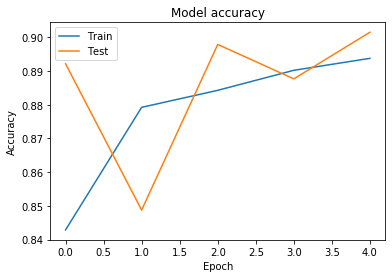

In [35]:
import matplotlib.pyplot as plot

plot.plot(historial_entranamiento.history['accuracy'])
plot.plot(historial_entranamiento.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

### Evaluación del modelo MLP con datos de validation

In [36]:
model_mlp_1.evaluate(val_generator, verbose=1)

  ...
    to  
  ['...']
624/624 [==============================] - 120s 192ms/step - loss: 0.2452 - accuracy: 0.8982


[0.24522054892104977, 0.8981565]

### CNN

In [71]:
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.layers as Layers
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils import to_categorical

cnn_model = Models.Sequential()

cnn_model.add(Layers.Conv2D(4,kernel_size=(3,3),activation="relu",input_shape=(70,70,3)))
cnn_model.add(Layers.MaxPool2D(3,3))

cnn_model.add(Layers.Flatten())
cnn_model.add(Layers.Dense(200,activation="relu"))
cnn_model.add(Layers.Dropout(0.4))
cnn_model.add(Layers.Dense(150,activation="relu"))
cnn_model.add(Layers.Dropout(0.4))
cnn_model.add(Layers.Dense(100,activation="relu"))
cnn_model.add(Layers.Dropout(0.4))
cnn_model.add(Layers.Dense(50,activation="relu"))
cnn_model.add(Layers.Dropout(0.4))
cnn_model.add(Layers.Dense(1,activation="sigmoid"))

cnn_model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 4)         112       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 4)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1936)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 200)               387400    
_________________________________________________________________
dropout_11 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 150)               30150     
_________________________________________________________________
dropout_12 (Dropout)         (None, 150)              

### Entrenamiento del modelo CNN

In [72]:
historial_entranamiento_cnn= cnn_model.fit(train_generator, epochs=10,validation_data=test_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5087 steps, validate for 621 steps
Epoch 1/10
5087/5087 [==============================] - 4224s 830ms/step - loss: 0.3968 - accuracy: 0.8081 - val_loss: 0.2593 - val_accuracy: 0.8892
Epoch 2/10
5087/5087 [==============================] - 911s 179ms/step - loss: 0.2751 - accuracy: 0.8881 - val_loss: 0.2423 - val_accuracy: 0.8953
Epoch 3/10
5087/5087 [==============================] - 2827s 556ms/step - loss: 0.2564 - accuracy: 0.8952 - val_loss: 0.2350 - val_accuracy: 0.8995
Epoch 4/10
5087/5087 [==============================] - 26012s 5s/step - loss: 0.2435 - accuracy: 0.9004 - val_loss: 0.2337 - val_accuracy: 0.9012
Epoch 5/10
5087/5087 [==============================] - 2288s 450ms/step - loss: 0.2344 - accuracy: 0.9049 - val_loss: 0.2241 - val_accuracy: 0.9036
Epoch 6/10
5087/5087 [==============================] - 200s 39ms/step - loss: 0.2258 - accuracy: 0.9081 - val_loss: 0.2252 - val_accuracy: 0.9034
Epoch 7/10
5087/

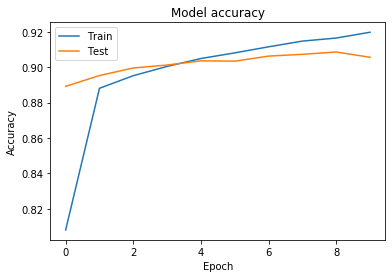

In [73]:
plot.plot(historial_entranamiento_cnn.history['accuracy'])
plot.plot(historial_entranamiento_cnn.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

### Evaluación del modelo CNN con datos de validation

In [74]:
cnn_model.evaluate(val_generator, verbose=1)

  ...
    to  
  ['...']
624/624 [==============================] - 142s 228ms/step - loss: 0.2243 - accuracy: 0.9054 - loss: 0.2243 


[0.22428002229963356, 0.9053702]

## Predicciones 

A continuación mostraremos ejemplos de predicciones correctas e incorrectas por parte de ambos modelos. Lo que haremos es mostrar la diferencia existente en las predicciones de los modelos con el mismo conjunto de imágenes de entrada.

In [131]:
class_names=["0","1"]
image_batch, classes_batch = next(val_generator)
total_imagenes = image_batch.shape[0]

In [1]:

def predicciones(model): 
    predicciones_correctas = 0
    predicciones_incorrectas = 0
 
    predicted_batch = model.predict(image_batch)
    for k in range(0,total_imagenes):
        imagen = image_batch[k]
        pred = predicted_batch[k]
        the_pred=int(round(pred[0]))
        prediccion = class_names[the_pred]
        porcentaje_confianza = max(pred)
        clase=int(classes_batch[k])
        nombre_clase = class_names[clase]
        plt.figure(k)
        isTrue = (the_pred == clase)
        if(isTrue):
            predicciones_correctas= predicciones_correctas + 1 
        else: 
            predicciones_incorrectas = predicciones_incorrectas + 1 
        
        plt.title(str(isTrue) + ' - clase: ' + nombre_clase + ' - ' + 'predicción: ' + prediccion + ' - Confianza: [' + str(porcentaje_confianza) + ']')
        plt.imshow(imagen)
    
    return [predicciones_correctas, predicciones_incorrectas]


### Análisis de las predicciones de MLP

C:\Users\maxi_\miniconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Cantidad de predicciones correctas: 28
Cantidad de predicciones incorrectas: 4


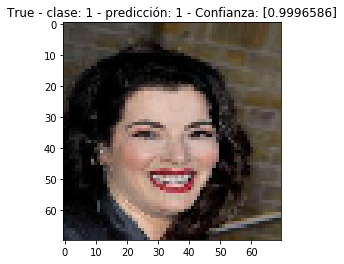

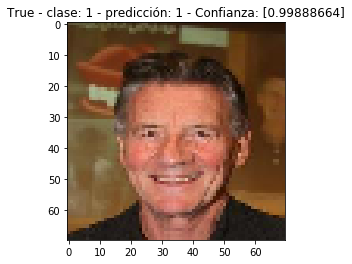

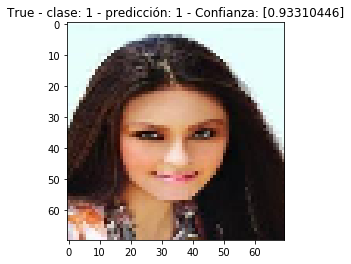

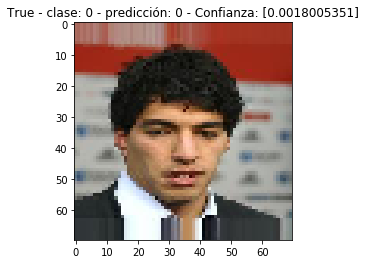

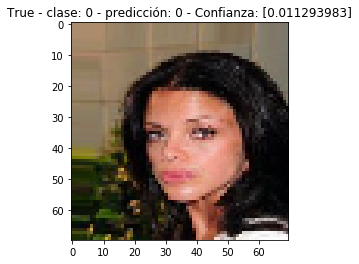

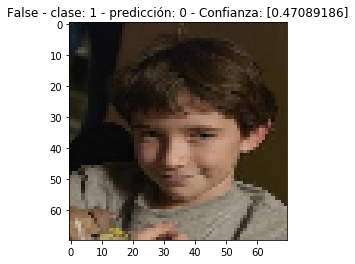

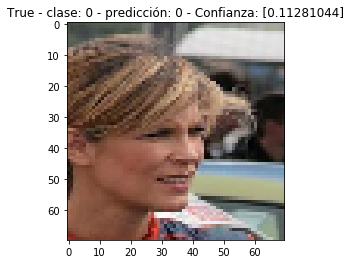

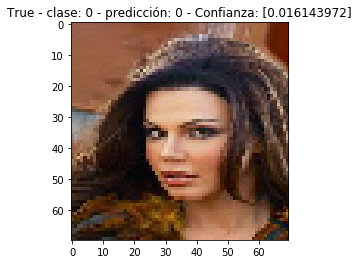

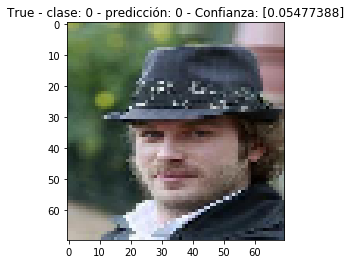

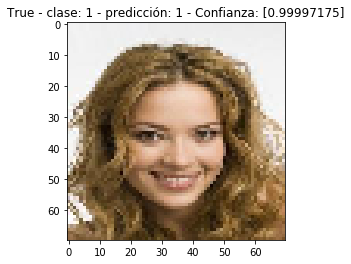

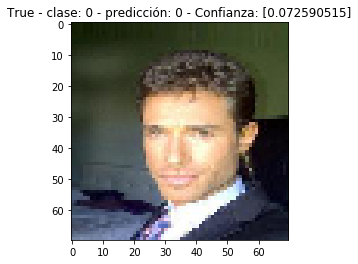

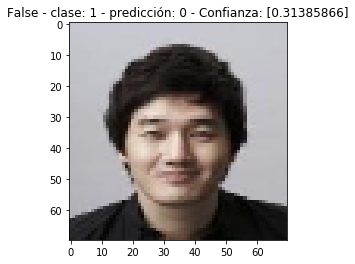

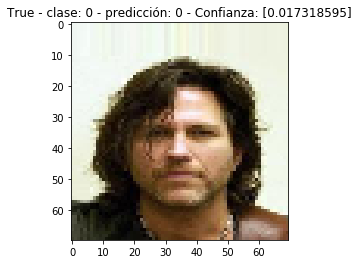

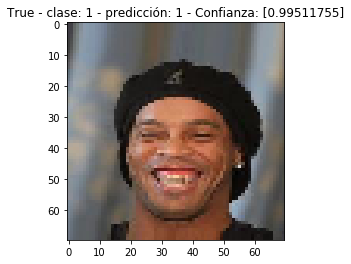

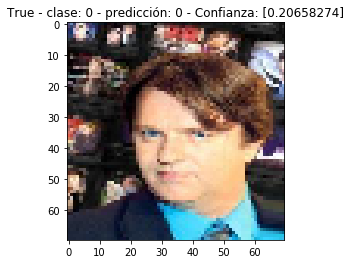

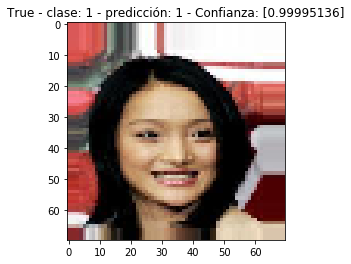

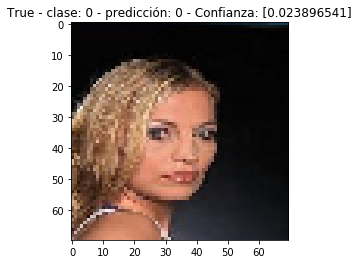

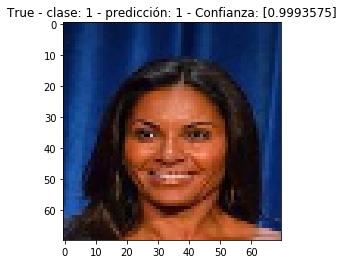

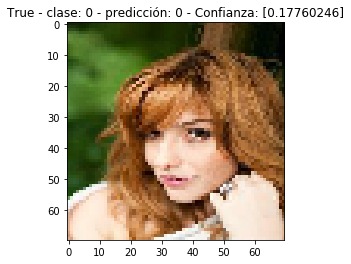

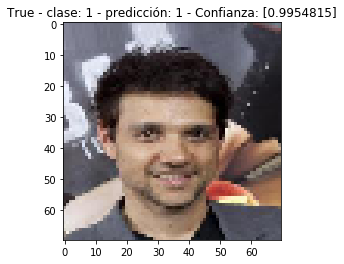

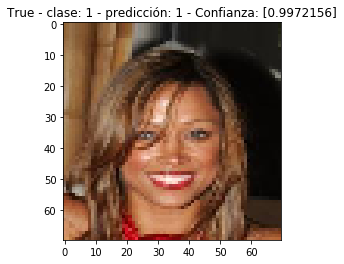

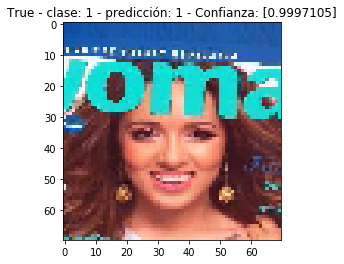

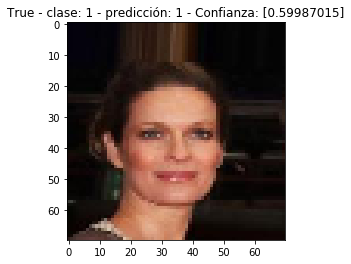

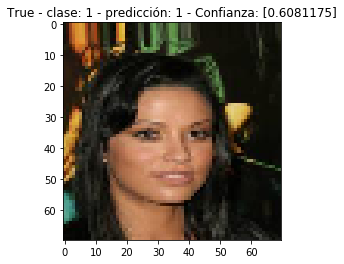

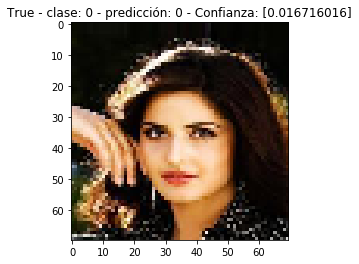

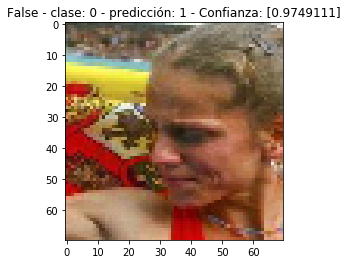

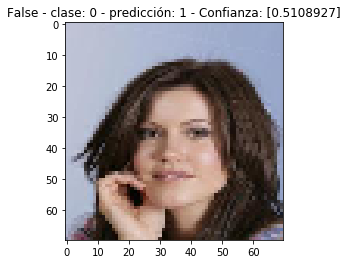

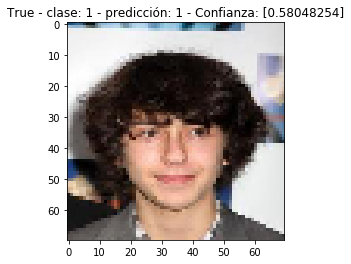

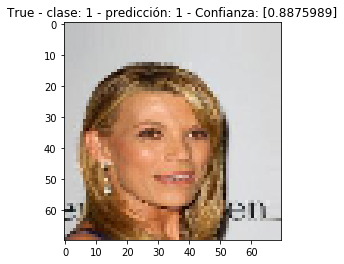

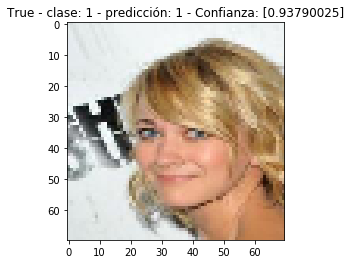

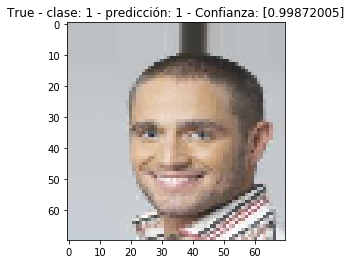

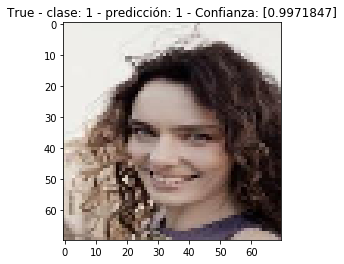

In [145]:
resultados = [] 
resultados = predicciones(model_mlp_1)
print("Cantidad de predicciones correctas: "+ str(resultados[0]))
print("Cantidad de predicciones incorrectas: "+ str(resultados[1]))

### Análisis de las predicciones de CNN

Cantidad de predicciones correctas: 29
Cantidad de predicciones incorrectas: 3


C:\Users\maxi_\miniconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


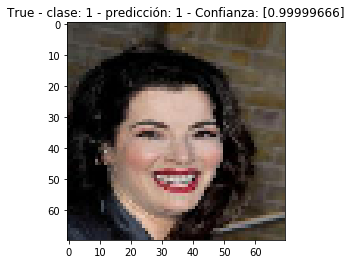

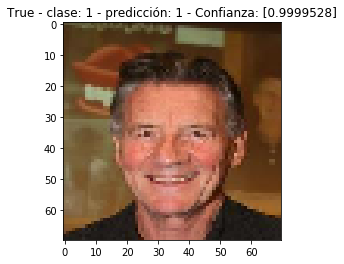

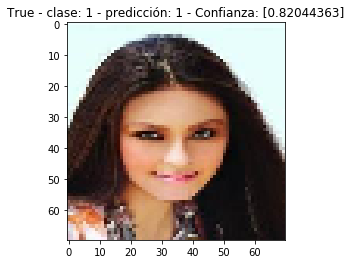

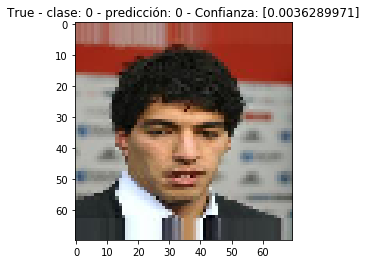

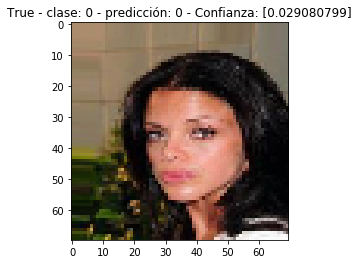

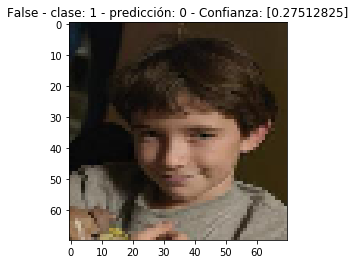

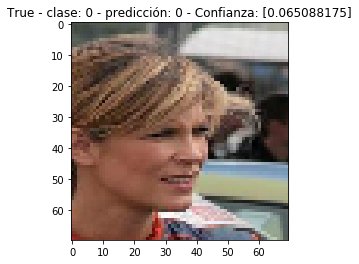

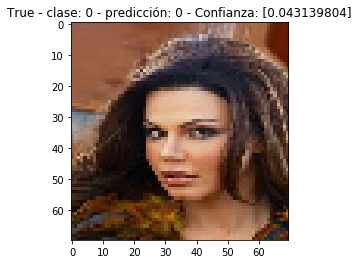

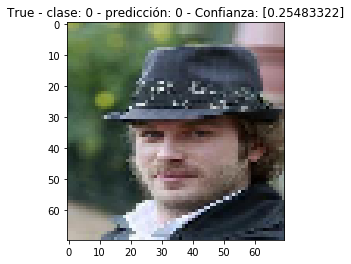

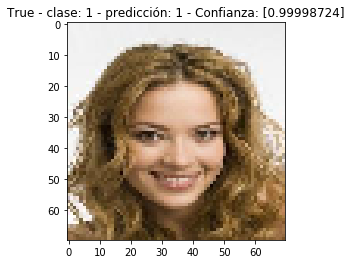

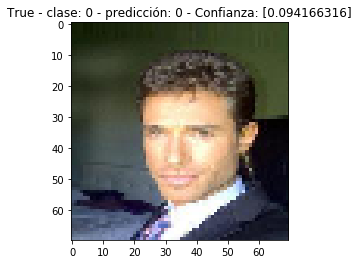

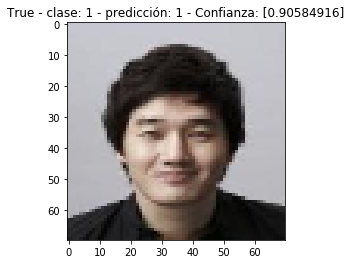

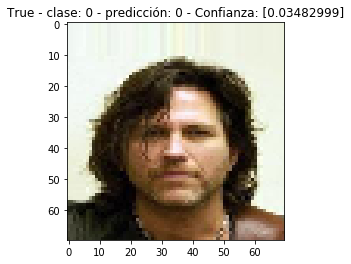

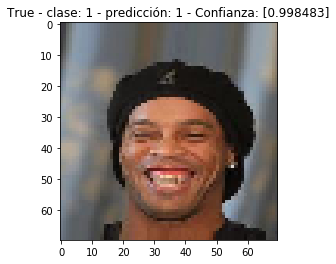

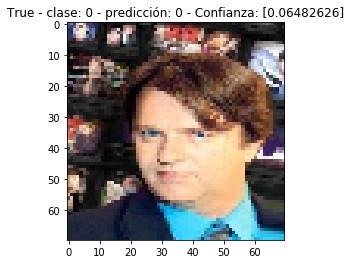

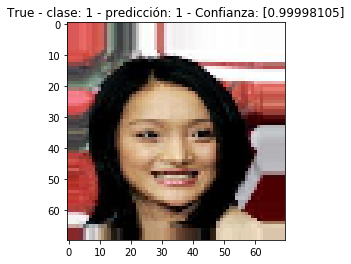

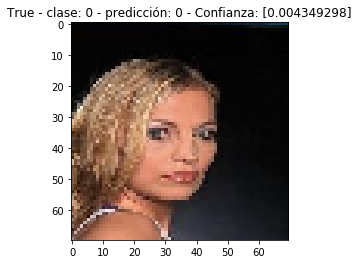

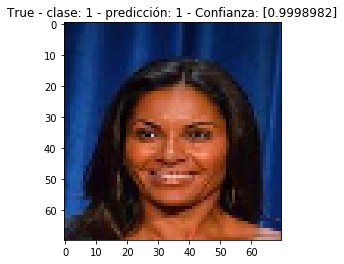

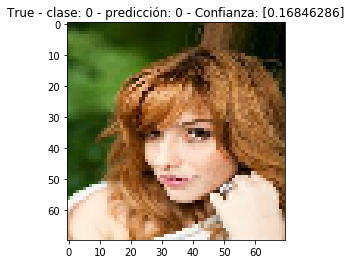

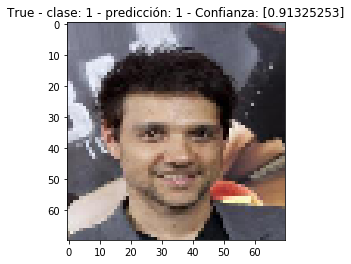

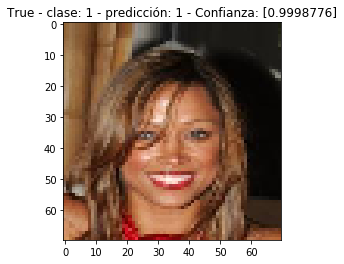

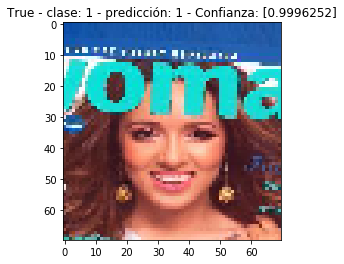

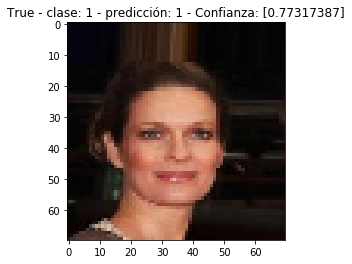

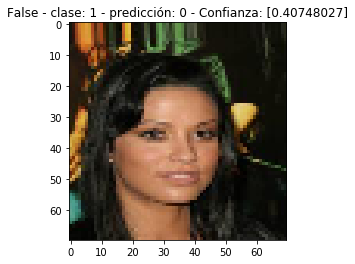

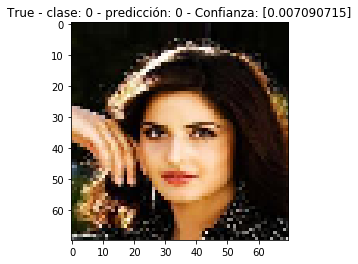

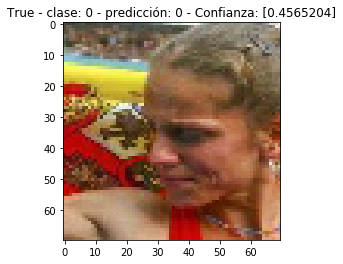

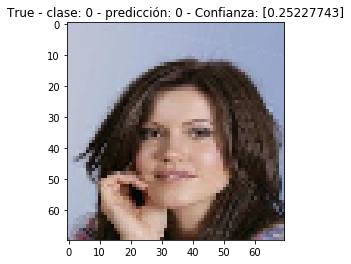

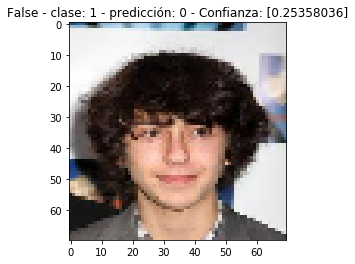

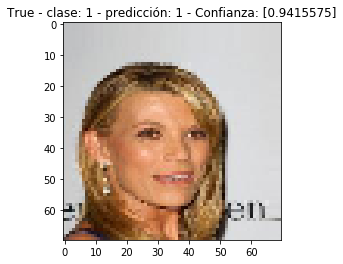

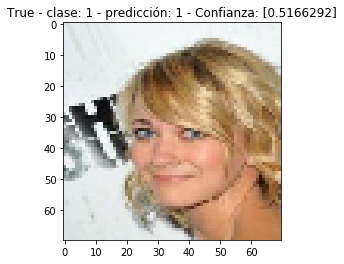

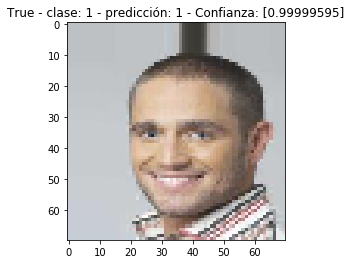

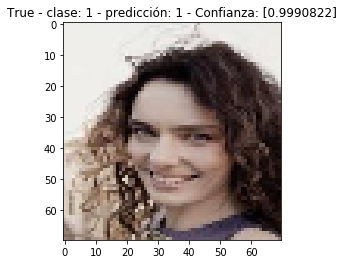

In [146]:
resultados_cnn = [] 
resultados_cnn = predicciones(cnn_model)
print("Cantidad de predicciones correctas: "+ str(resultados_cnn[0]))
print("Cantidad de predicciones incorrectas: "+ str(resultados_cnn[1]))

## Conclusiones

### Comentario adicional:

En un principio debido a la gran cantidad de datos existentes para cada dataset de train, test y validation, lo que hicimos fue tomar el 20% de los datos disponibles para train, el 20% de los datos disponibles para test y el 50% de validación. En ese momento por cada uno de ellos formabamos por ejemplo: X_train , y_train , en donde a X_train le pasabamos las imágenes procesadas y a y_train las etiquetas correspondientes a dichas imágenes implementando la misma metodología con los restantes.

Código utilizado:  
imagenes_entrada=[]  
Etiquetas= data['Smiling']  
imagenes = os.listdir('imagenes_tp3_cv/')  

for i in imagenes:  
     imagen = cv2.imread('imagenes_tp3_cv/'+i)       
     imagen_array=Image.fromarray(imagen,"RGB")        
     size_imagen=image_to_array.resize((70,70))        
     imagenes_entrada.append(np.array(size_image))  
      
      
Luego formábamos los conjuntos de train, set y validation. 

Ejemplo: 
X_train = imagenes_entrada_train 
y_train = etiquetas_train 


Realizando esto, al entrenar los modelos, obteniamos valores en accuracy debajo de los 0.60, sin importar la manera de definir las capas y parámetros de los mismos. 

**Los resultados comenzaron a ser muy distintos cuando se optó por utilizar data generator de keras.**


### Conclusión MLP:

En un principio al configurar el modelo no utilizábamos las capas de Dropout intermedias entre cada una de las capas que contiene neuronas. Como estudiamos durante la materia, notamos como el modelo generaba muy buenos resultados en train, pero no accurría lo mismo con los resultados de las métrcias utilizando el conjunto de test, es decir, sobreentrenaba. Aquí se podía obtener los resultados correspondientes al historial del entrenamiento mucho más rapido con respecto a los próximos que mencionaremos a continuación. 

Con lo que respecta al modelo que decidimos dejar en el notebook, consideramos que es el más apropiado y el que mejor resultados nos brindó. Anteriormente probamos un modelo similar pero con una mayor cantidad de neuronas en cada una de las capas, que además de tardar más, arrojó resultados casi idénticos al modelo seleccionado. 

Desde un comienzo, sosteníamos que MLP no nos iba a brindar los resultados que alcanzamos, pero sin embargo, si observamos otra métrica, como por ejemplo la curva de aprendizaje, podemos ver que la misma presenta ciertas irregularidaes, constantemente muestra altibajos, sin lograr estabilizarse en ningún momento a lo largo de todo el entrenamiento. Además consideramos que si incrementaríamos la cantidad de épocas, continuaría teniendo el mismo comportamiento. 

### Conclusión CNN:

En este caso, los tiempos necesarios para realizar el entrenamiento del modelo son mayores  que en lugar de MLP. Sin embargo en el mismo, podemos observar que a comparación del modelo de MLP, obtuvimos mejores resultados tanto en train como test y validation, los cuales se podrían mejorar, claramente, agregando mas neuronas en cada una de las capas, y una mayor cantidad de épocas de entrenamiento pero para ello, necesitaríamos de más tiempo y más hardware.


## Conclusión final

Con respecto a los resultados obtenidos en la muestra sobre las predicciones de ambos modelos sobre las mismas imágenes,no encontramos mucha diferencia, sólo que **el modelo correspondiente a cnn tiene 3 predicciones incorrectas mientras que el de mlp 4.**

Si bien, estamos trabajando sobre una pequeña parte de los datos de validation, sólo 32 imágenes y no estamos viendo los resultados de la predicción total, sostenemos que el modelo correspondiente a cnn, podría arrojar mejores resultados en comparación a mlp, para ello, deberíamos tener los recursos necesarios. 